In [ ]:
!pip install dask dask[dataframe] dask-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


Mounted at /content/drive
[########################################] | 100% Completed | 337.86 ms
[########################################] | 100% Completed | 102.51 ms
[########################################] | 100% Completed | 1.70 s
[########################################] | 100% Completed | 102.30 ms
[########################################] | 100% Completed | 103.37 ms
[########################################] | 100% Completed | 102.25 ms
[########################################] | 100% Completed | 102.42 ms
[########################################] | 100% Completed | 881.57 ms
[########################################] | 100% Completed | 102.68 ms
[########################################] | 100% Completed | 101.89 ms
[########################################] | 100% Completed | 102.13 ms
[########################################] | 100% Completed | 102.05 ms
[########################################] | 100% Completed | 102.26 ms
[########################################

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Tempo de treinamento para o fold: 12889.66723060608 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Tempo de treinamento para o fold: 24326.63364839554 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Tempo de treinamento para o fold: 33812.63979887962 segundos
Tempo de treinamento para o fold: 43467.99188184738 segundos
Tempo de treinamento para o fold: 52893.94834136963 segundos
Tempo de treinamento total: 11971.301654100418 segundos

Modelo: SVM
Acurácia: 0.7871340731853629
Precisão: 0.7933706275440847
Recall: 0.7871340731853629
F1-Score: 0.7765468921573488


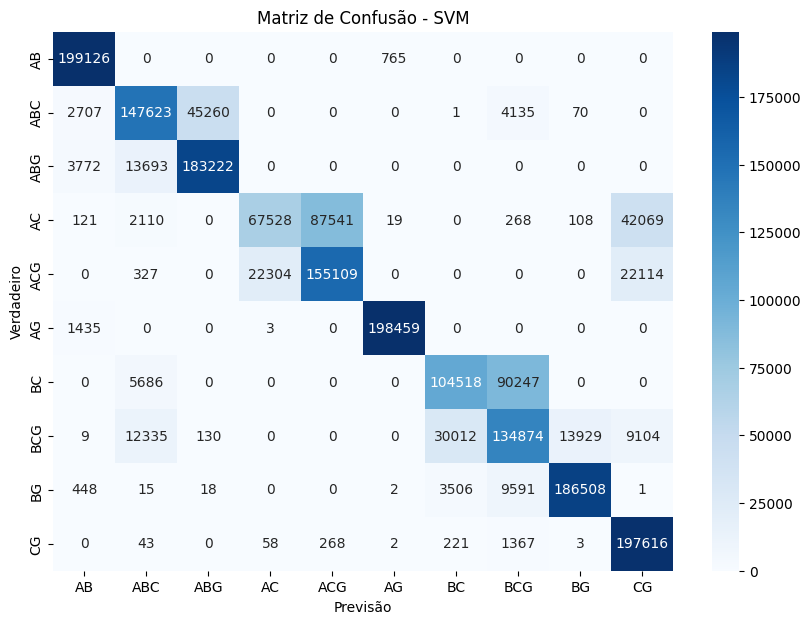

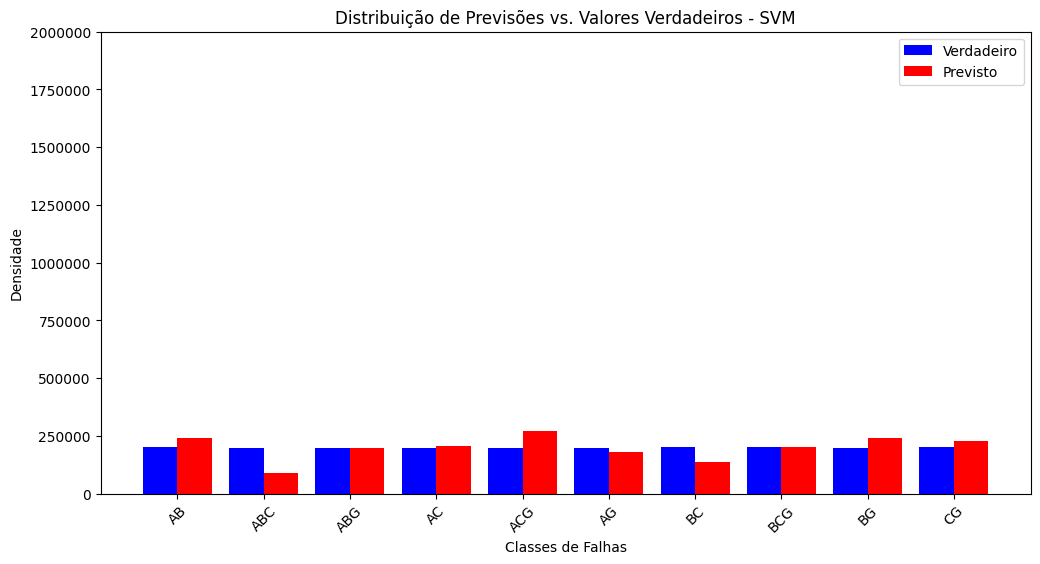

In [ ]:
import os
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask_ml.preprocessing import StandardScaler as DaskScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Monta o Google Drive
drive.mount('/content/drive')

# Função para carregar e pré-processar os dados usando Dask, removendo espaços em branco e duplicatas
def process_data(filepath, cols_to_use):
    df = dd.read_csv(filepath, usecols=cols_to_use)
    df = df.drop_duplicates().fillna(df.mean())
    df = df.map_partitions(lambda x: x.apply(lambda col: col.str.strip() if col.dtype == "object" else col))
    scaler = DaskScaler()
    df = scaler.fit_transform(df)
    return df

# Função para adicionar rótulos
def add_labels(df, label):
    df['label'] = label
    return df

# Função para processar arquivos em uma pasta
def process_files_in_folder(folder_path, cols_to_use, label):
    files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    if files:
        dfs = [process_data(file, cols_to_use) for file in files]
        df = dd.concat(dfs, axis=0)
        df = df.map_partitions(lambda df_partition: add_labels(df_partition, label))
        return df
    else:
        print(f"No CSV files found in {folder_path}")
        return None

# Função para processar todas as pastas e realizar a divisão de dados
def prepare_and_split_data(base_path, subfolders):
    folder_dfs = []
    for subfolder in subfolders:
        folder_path = os.path.join(base_path, subfolder)
        df = process_files_in_folder(folder_path, ['v:X0014A', 'v:X0014B', 'v:X0014C', 'v:X0013A', 'v:X0013B', 'v:X0013C',
                                                    'c:X0013A:BUS8A', 'c:X0013B:BUS8B', 'c:X0013C:BUS8C',
                                                    'c:BUS9A:X0014A', 'c:BUS9B:X0014B', 'c:BUS9C:X0014C'], subfolder)
        if df is not None:
            folder_dfs.append(df)

    if folder_dfs:
        final_df = dd.concat(folder_dfs, axis=0).compute()
        X = final_df.drop('label', axis=1)
        y = final_df['label']
        return train_test_split(X, y, test_size=0.2, random_state=42)
    else:
        return None, None, None, None

base_path = '/content/drive/MyDrive/Amostra'
subfolders = ['AB', 'ABC', 'ABG', 'AC', 'ACG', 'AG', 'BG', 'BCG', 'BC', 'CG']

with ProgressBar():
    X_train, X_test, y_train, y_test = prepare_and_split_data(base_path, subfolders)

# Balanceamento SMOTE
smote = SMOTE(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Ajuste do modelo SVM com hiperparâmetros
svm_model = SVC(max_iter=1000, tol=1e-3, random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Medição do tempo durante a validação cruzada
start_time = time.time()
for train_index, test_index in kf.split(X_train_resampled):
    X_fold_train, X_fold_test = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
    y_fold_train, y_fold_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    svm_model.fit(X_fold_train, y_fold_train)
    fold_time = time.time() - start_time
    print(f"Tempo de treinamento para o fold: {fold_time} segundos")

# Treinamento final do modelo e avaliação
start_time = time.time()
svm_model.fit(X_train_resampled, y_train_resampled)
training_time = time.time() - start_time
print(f"Tempo de treinamento total: {training_time} segundos")

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibindo métricas
print(f"\nModelo: SVM")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {fscore}")

# Funções para plotar a matriz de confusão e histograma
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matriz de Confusão - SVM')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()

def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    categories = np.unique(np.concatenate((y_test, y_pred)))
    bins = np.arange(len(categories) + 1) - 0.5
    plt.hist([y_test, y_pred], bins=bins, color=['blue', 'red'], label=['Verdadeiro', 'Previsto'], align='mid', rwidth=0.8)
    plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    plt.title('Distribuição de Previsões vs. Valores Verdadeiros - SVM')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.ylim(0, 2000000)  # Ajusta o limite do eixo y
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend()
    plt.show()

labels = np.unique(np.concatenate((y_train_resampled, y_test)))
plot_confusion_matrix(conf_matrix, labels=labels)
plot_predictions_vs_true(y_test, y_pred)


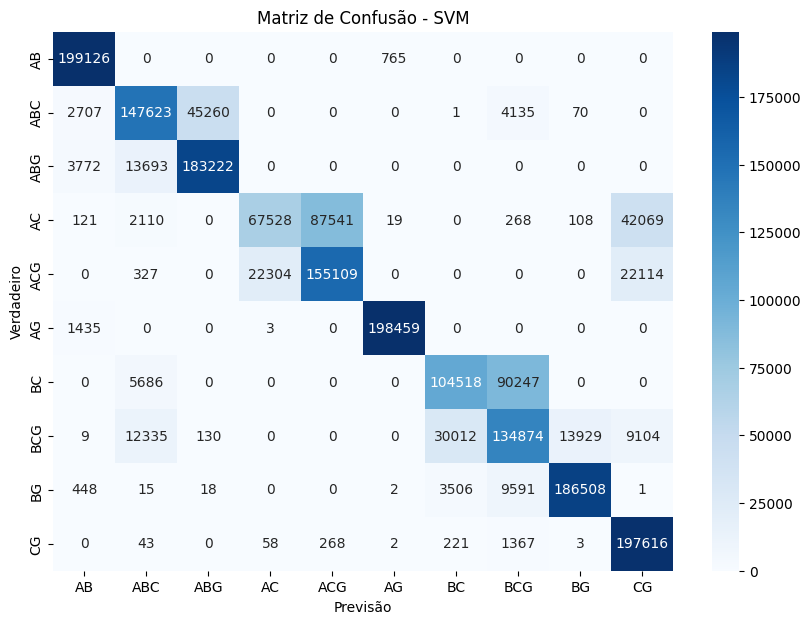

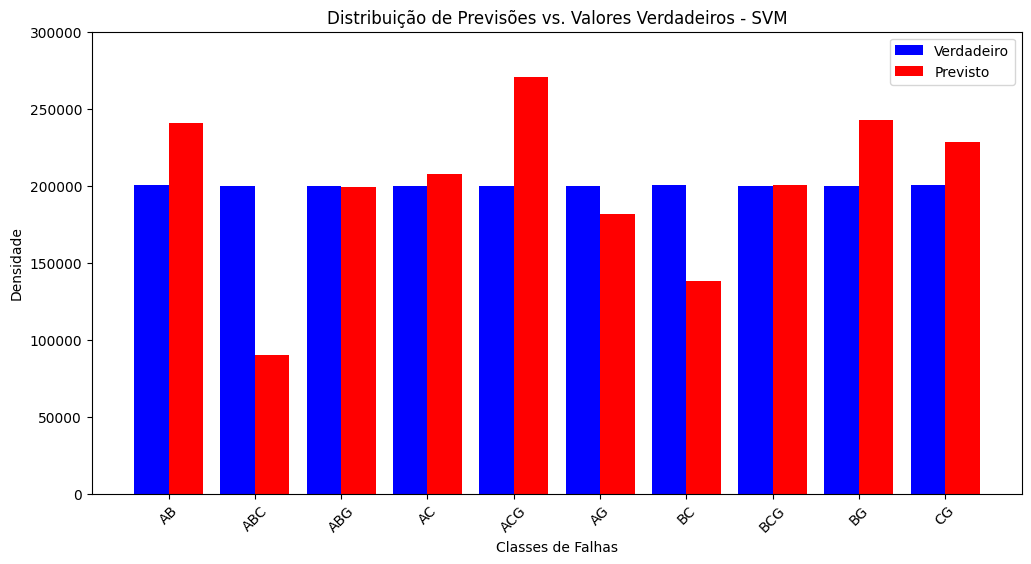

In [ ]:

def plot_predictions_vs_true(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    categories = np.unique(np.concatenate((y_test, y_pred)))
    bins = np.arange(len(categories) + 1) - 0.5
    plt.hist([y_test, y_pred], bins=bins, color=['blue', 'red'], label=['Verdadeiro', 'Previsto'], align='mid', rwidth=0.8)
    plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
    plt.title('Distribuição de Previsões vs. Valores Verdadeiros - SVM')
    plt.xlabel('Classes de Falhas')
    plt.ylabel('Densidade')
    plt.ylim(0, 300000)  # Ajusta o limite do eixo y
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend()
    plt.show()


labels = np.unique(np.concatenate((y_train_resampled, y_test)))
plot_confusion_matrix(conf_matrix, labels=labels)
plot_predictions_vs_true(y_test, y_pred)